In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/hotdog_data')
try:
  os.makedirs(local_download_path)
except: pass

file_id = '13AJmziPNl8beOmkMYQ1ilc2SNPnPJZi3'

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
#file_lists = [drive.ListFile({'q': "{} in parents".format('{}'.format(oneid))}).GetList() for oneid in ids]

file_lists = []
file_list = drive.ListFile({'q': "'{}' in parents".format(file_id)}).GetList()
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


#with open(fname, 'r') as f:
#  print(f.read())

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
import glob
import random
import tensorflow as tf
import zipfile

In [3]:
os.path.expanduser('~/hotdog_data')
zip_path = '{}/hot-dog-not-hot-dog.zip'.format(local_download_path)
zip_path
os.listdir(local_download_path)
zip_path

'/content/hotdog_data/hot-dog-not-hot-dog.zip'

In [0]:
zip_ref = zipfile.ZipFile('{}/hot-dog-not-hot-dog.zip'.format(local_download_path), 'r')
zip_ref.extractall(local_download_path)
zip_ref.close()
zip_ref = zipfile.ZipFile('{}/seefood.zip'.format(local_download_path), 'r')
zip_ref.extractall(local_download_path)
zip_ref.close()

In [5]:
os.listdir('{}/test'.format(local_download_path))

['hot_dog', 'not_hot_dog']

In [0]:
test_image_paths = [glob.glob('{}/test/hot_dog/*'.format(local_download_path)) , glob.glob('{}/test/not_hot_dog/*'.format(local_download_path))]
train_image_paths = [glob.glob('{}/train/hot_dog/*'.format(local_download_path)) , glob.glob('{}/train/not_hot_dog/*'.format(local_download_path))]
for i in range(201):
  train_image_paths[0].append(test_image_paths[0][i])
  train_image_paths[1].append(test_image_paths[1][i])

In [6]:
len(test_image_paths[0])

250

In [7]:
#img_ctrs keeps track of the images used from each digit set
#every time a batch is gotten, a random integer 'ind' is seleced b/w 0 and 9 (to select the digit)
#img_ctrs[ind] is the position of the image in 'ind' digit set that is added to the batch
#img_ctrs[ind] is then incremented

img_ctrs = [0 for i in range(2)]
max_imgs_per_type = 450
my_batch_size = 50

#the 10 labels 
one_hot_vectors = [[(lambda i,j: int(i == j))(i,j)  for i in range(2)] for j in range(2)]
one_hot_vectors = np.array(one_hot_vectors)
one_hot_vectors

array([[1, 0],
       [0, 1]])

In [0]:
def get_image(path):
  pic = io.imread(path)
  return resize(pic,(64,64))

def get_images(paths, img_ctrs, max_imgs_per_type):
  batch1 = []
  labels1 = []
  
  max_ind = max_imgs_per_type + img_ctrs[0]
  for i in range(2 * max_imgs_per_type):
    ind = random.randint(0,1)
    if(img_ctrs[ind] >= max_ind):
      ind = int(not ind)    
    image = get_image(paths[ind][img_ctrs[ind]])      
    img_ctrs[ind] += 1
    batch1.append(image)
    labels1.append(one_hot_vectors[ind])
  return np.array(batch1),np.array(labels1)
  

In [10]:
train_images,train_labels = get_images(train_image_paths, [0,0], 450)
print(len(train_images))
test_images, test_labels = get_images(test_image_paths, [201,201], 49)
len(test_images)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


900


98

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


[0 1]


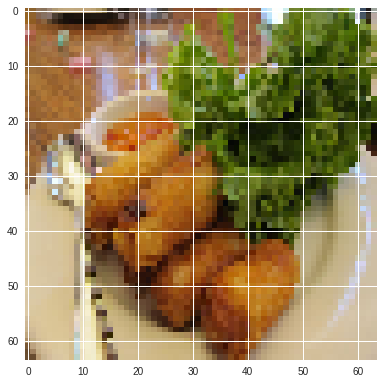

In [11]:
io.imshow(train_images[40])
print(train_labels[40])

In [0]:

def get_batch_and_labels(batch_size, i):
  batch = []
  labels = []
  
  if i + batch_size >= len(train_images):
    batch = train_images[i:]
    labels = train_labels[i:]
    batch = np.concatenate((batch,train_images[:batch_size + i - len(train_images)]))
    labels = np.concatenate((labels, train_labels[:batch_size + i - len(train_labels)]))
  else:
    batch = train_images[i:i + batch_size]
    labels = train_labels[i:i + batch_size]
  return np.array(batch), np.array(labels)


(100, 64, 64, 3)


array([0, 1])

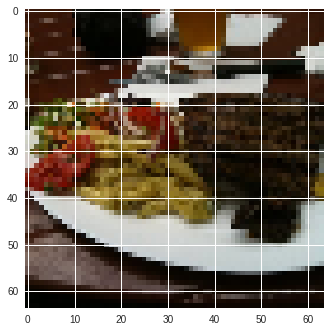

In [13]:
t_batch, t_labels = get_batch_and_labels(100,850)
print(t_batch.shape)
plt.imshow(t_batch[65])
t_labels[65]

In [0]:
n_epochs = 400
minibatch_size = 40
lr = 1e-4
keep = 0.5

In [0]:
x = tf.placeholder(tf.float32, shape = [None, 64,64 , 3])

y_ = tf.placeholder(tf.float32, shape = [None, 2])

In [0]:
def weight_variable(shape):
    """Initializes weights randomly from a normal distribution
    Params: shape: list of dimensionality of the tensor to be initialized
    """
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Initializes the bias term randomly from a normal distribution.
    Params: shape: list of dimensionality for the bias term.
    """
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    """Performs a convolution over a given patch x with some filter W.
    Uses a stride of length 1 and SAME padding (padded with zeros at the edges)
    Params:
    x: tensor: the image to be convolved over
    W: the kernel (tensor) with which to convolve.
    """
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# strides is a length-4 list that specifies the amount to move for each dimension of our input x. 
# the dimensions correspond to the following (in order): batch_size, length of image, width of image, # of channels in image

def max_pool_2x2(x):
    """Performs a max pooling operation over a 2 x 2 region"""
    # ksize: we only want to take the maximum over 1 example and 1 channel. 
    # the middle elements are 2 x 2 because we want to take maxima over 2 x 2 regions
    
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME') # stride 2 right and 2 down

In [17]:
W_conv1 = weight_variable([3, 3, 3, 16]) # 3 x 3 kernel, across an image with 3 channels to 16 channels
b_conv1 = bias_variable([16])
h_conv1 = tf.nn.relu(tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool1
#h_conv1

<tf.Tensor 'MaxPool:0' shape=(?, 32, 32, 16) dtype=float32>

In [18]:
W_conv2 = weight_variable([3, 3, 16, 32])
b_conv2 = bias_variable([32])
h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool2

<tf.Tensor 'MaxPool_1:0' shape=(?, 16, 16, 32) dtype=float32>

In [20]:
W_conv3 = weight_variable([3, 3, 32, 64]) 
b_conv3 = bias_variable([64])
h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3)
h_pool3 = tf.nn.max_pool(h_conv3, ksize=[1, 2,2, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool3
#h_conv3

<tf.Tensor 'MaxPool_3:0' shape=(?, 8, 8, 64) dtype=float32>

In [21]:
W_conv4 = weight_variable([3, 3, 64, 64]) 
b_conv4 = bias_variable([64])
h_conv4 = tf.nn.relu(tf.nn.conv2d(h_pool3, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + b_conv4)
h_pool4 = tf.nn.max_pool(h_conv4, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool4

<tf.Tensor 'MaxPool_4:0' shape=(?, 4, 4, 64) dtype=float32>

In [0]:
W_conv5 = weight_variable([3, 3, 64, 64]) 
b_conv5 = bias_variable([64])
h_conv5 = tf.nn.relu(tf.nn.conv2d(h_pool4, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + b_conv5)
#h_pool5 = tf.nn.max_pool(h_conv5, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
#h_pool5
h_conv5

<tf.Tensor 'Relu_54:0' shape=(?, 32, 32, 64) dtype=float32>

In [0]:
W_conv6 = weight_variable([3, 3, 64, 128])
b_conv6 = bias_variable([128])
h_conv6 = tf.nn.relu(tf.nn.conv2d(h_conv5, W_conv6, strides=[1, 1, 1, 1], padding='SAME') + b_conv6)
h_pool6 = tf.nn.max_pool(h_conv6, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool6

<tf.Tensor 'MaxPool_26:0' shape=(?, 16, 16, 128) dtype=float32>

In [0]:
W_conv7 = weight_variable([3, 3, 128, 128]) 
b_conv7 = bias_variable([128])
h_conv7 = tf.nn.relu(tf.nn.conv2d(h_pool6, W_conv7, strides=[1, 1, 1, 1], padding='SAME') + b_conv7)
h_pool7 = tf.nn.max_pool(h_conv7, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool7

<tf.Tensor 'MaxPool_27:0' shape=(?, 8, 8, 128) dtype=float32>

In [0]:
W_conv8 = weight_variable([3, 3, 512, 512]) 
b_conv8 = bias_variable([512])
h_conv8 = tf.nn.relu(tf.nn.conv2d(h_pool7, W_conv8, strides=[1, 1, 1, 1], padding='SAME') + b_conv8)
h_pool8 = tf.nn.max_pool(h_conv8, ksize=[1, 2, 2, 1],strides=[1, 1, 1, 1], padding='SAME')
h_pool8

<tf.Tensor 'MaxPool_76:0' shape=(?, 25, 25, 512) dtype=float32>

In [0]:
W_conv9 = weight_variable([3, 3, 512, 1024]) 
b_conv9 = bias_variable([1024])
h_conv9 = tf.nn.relu(tf.nn.conv2d(h_pool8, W_conv9, strides=[1, 2, 2, 1], padding='SAME') + b_conv9)
h_pool9 = tf.nn.max_pool(h_conv9, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
h_pool9

<tf.Tensor 'MaxPool_77:0' shape=(?, 7, 7, 1024) dtype=float32>

In [0]:
W_fc1 = weight_variable([4 * 4 * 64, 512]) 
b_fc1 = bias_variable([512])
h_conv_flat = tf.reshape(h_pool4, [-1, 4 * 4 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_conv_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [0]:
W_fc2 = weight_variable([512, 128])
b_fc2 = bias_variable([128])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

In [0]:
W_fc3 = weight_variable([128, 2])
b_fc3 = bias_variable([2])
y_out = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

In [0]:
#num_ep_per_dec = 350
#decay_steps = int(minibatch_size * num_ep_per_dec)
#global_step = tf.train.get_or_create_global_step()

#lr = tf.train.exponential_decay(0.1, global_step, decay_steps,0.1, staircase=True)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_out, labels = y_)
#opt = tf.train.GradientDescentOptimizer(lr)
#grads = opt.compute_gradients(cross_entropy)
#apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_, axis = 1), tf.argmax(y_out, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

In [27]:
 
with tf.Session() as sess:
  sess.run(init)
  for i in range(n_epochs):
    training_inputs, training_labels = get_batch_and_labels(minibatch_size, i*minibatch_size)    
    if i % 1 == 0:
      print("epoch:{}".format(i))
      #print(img_ctrs)
      #print(training_labels)
      train_acc = accuracy.eval(feed_dict = {x: training_inputs, y_: training_labels, keep_prob : 1.0})
      print("training accuracy: {}".format(train_acc))
    sess.run([train_step], feed_dict = {x: training_inputs, y_: training_labels, keep_prob : keep})
  test_acc = accuracy.eval(feed_dict = {x: test_images, y_: test_labels, keep_prob : 1.0})
  print("test accuracy: {}".format(test_acc))

epoch:0
training accuracy: 0.5249999761581421
epoch:1
training accuracy: 0.4000000059604645
epoch:2
training accuracy: 0.5
epoch:3
training accuracy: 0.625
epoch:4
training accuracy: 0.6499999761581421
epoch:5
training accuracy: 0.44999998807907104
epoch:6
training accuracy: 0.44999998807907104
epoch:7
training accuracy: 0.4749999940395355
epoch:8
training accuracy: 0.375
epoch:9
training accuracy: 0.42500001192092896
epoch:10
training accuracy: 0.44999998807907104
epoch:11
training accuracy: 0.4000000059604645
epoch:12
training accuracy: 0.5
epoch:13
training accuracy: 0.42500001192092896
epoch:14
training accuracy: 0.550000011920929
epoch:15
training accuracy: 0.6000000238418579
epoch:16
training accuracy: 0.75
epoch:17
training accuracy: 0.44999998807907104
epoch:18
training accuracy: 0.699999988079071
epoch:19
training accuracy: 0.5
epoch:20
training accuracy: 0.574999988079071
epoch:21
training accuracy: 0.4749999940395355
epoch:22
training accuracy: 0.574999988079071
epoch:23
tra

epoch:62
training accuracy: 0.6177777647972107
epoch:63
training accuracy: 0.6222222447395325
epoch:64
training accuracy: 0.6344444155693054
epoch:65
training accuracy: 0.6377778053283691
epoch:66
training accuracy: 0.6433333158493042
epoch:67
training accuracy: 0.644444465637207
epoch:68
training accuracy: 0.6422222256660461
epoch:69
training accuracy: 0.6466666460037231
epoch:70
training accuracy: 0.6455555558204651
epoch:71
training accuracy: 0.653333306312561
epoch:72
training accuracy: 0.6600000262260437
epoch:73
training accuracy: 0.6588888764381409
epoch:74
training accuracy: 0.6622222065925598
epoch:75
training accuracy: 0.6600000262260437
epoch:76
training accuracy: 0.6611111164093018
epoch:77
training accuracy: 0.6566666960716248
epoch:78
training accuracy: 0.6577777862548828
epoch:79
training accuracy: 0.6555555462837219
epoch:80
training accuracy: 0.652222216129303
epoch:81
training accuracy: 0.652222216129303
epoch:82
training accuracy: 0.6566666960716248
epoch:83
training

epoch:126
training accuracy: 0.6944444179534912
epoch:127
training accuracy: 0.6911110877990723
epoch:128
training accuracy: 0.6866666674613953
epoch:129
training accuracy: 0.6899999976158142
epoch:130
training accuracy: 0.6933333277702332
epoch:131
training accuracy: 0.6977777481079102
epoch:132
training accuracy: 0.6922222375869751
epoch:133
training accuracy: 0.6911110877990723
epoch:134
training accuracy: 0.6922222375869751
epoch:135
training accuracy: 0.6911110877990723
epoch:136
training accuracy: 0.6922222375869751
epoch:137
training accuracy: 0.6977777481079102
epoch:138
training accuracy: 0.7011111378669739
epoch:139
training accuracy: 0.7011111378669739
epoch:140
training accuracy: 0.698888897895813
epoch:141
training accuracy: 0.699999988079071
epoch:142
training accuracy: 0.70333331823349
epoch:143
training accuracy: 0.7044444680213928
epoch:144
training accuracy: 0.7066666483879089
epoch:145
training accuracy: 0.7088888883590698
epoch:146
training accuracy: 0.7099999785423

epoch:190
training accuracy: 0.7688888907432556
epoch:191
training accuracy: 0.7666666507720947
epoch:192
training accuracy: 0.7677778005599976
epoch:193
training accuracy: 0.7711111307144165
epoch:194
training accuracy: 0.7744444608688354
epoch:195
training accuracy: 0.7777777910232544
epoch:196
training accuracy: 0.7733333110809326
epoch:197
training accuracy: 0.7766666412353516
epoch:198
training accuracy: 0.7811111211776733
epoch:199
training accuracy: 0.7877777814865112
epoch:200
training accuracy: 0.7866666913032532
epoch:201
training accuracy: 0.7900000214576721
epoch:202
training accuracy: 0.7788888812065125
epoch:203
training accuracy: 0.7777777910232544
epoch:204
training accuracy: 0.7833333611488342
epoch:205
training accuracy: 0.7900000214576721
epoch:206
training accuracy: 0.7888888716697693
epoch:207
training accuracy: 0.7855555415153503
epoch:208
training accuracy: 0.7877777814865112
epoch:209
training accuracy: 0.7877777814865112
epoch:210
training accuracy: 0.794444441

epoch:254
training accuracy: 0.8488888740539551
epoch:255
training accuracy: 0.8488888740539551
epoch:256
training accuracy: 0.8488888740539551
epoch:257
training accuracy: 0.8488888740539551
epoch:258
training accuracy: 0.846666693687439
epoch:259
training accuracy: 0.8500000238418579
epoch:260
training accuracy: 0.846666693687439
epoch:261
training accuracy: 0.851111114025116
epoch:262
training accuracy: 0.847777783870697
epoch:263
training accuracy: 0.8544444441795349
epoch:264
training accuracy: 0.855555534362793
epoch:265
training accuracy: 0.8611111044883728
epoch:266
training accuracy: 0.8533333539962769
epoch:267
training accuracy: 0.8566666841506958
epoch:268
training accuracy: 0.8655555844306946
epoch:269
training accuracy: 0.8655555844306946
epoch:270
training accuracy: 0.8655555844306946
epoch:271
training accuracy: 0.8633333444595337
epoch:272
training accuracy: 0.8711110949516296
epoch:273
training accuracy: 0.8677777647972107
epoch:274
training accuracy: 0.87000000476837

epoch:318
training accuracy: 0.9155555367469788
epoch:319
training accuracy: 0.9211111068725586
epoch:320
training accuracy: 0.9200000166893005
epoch:321
training accuracy: 0.9166666865348816
epoch:322
training accuracy: 0.9244444370269775
epoch:323
training accuracy: 0.9166666865348816
epoch:324
training accuracy: 0.9222221970558167
epoch:325
training accuracy: 0.9277777671813965
epoch:326
training accuracy: 0.9288889169692993
epoch:327
training accuracy: 0.9244444370269775
epoch:328
training accuracy: 0.9255555272102356
epoch:329
training accuracy: 0.9300000071525574
epoch:330
training accuracy: 0.9222221970558167
epoch:331
training accuracy: 0.9277777671813965
epoch:332
training accuracy: 0.9333333373069763
epoch:333
training accuracy: 0.9322222471237183
epoch:334
training accuracy: 0.9311110973358154
epoch:335
training accuracy: 0.9366666674613953
epoch:336
training accuracy: 0.9444444179534912
epoch:337
training accuracy: 0.9355555772781372
epoch:338
training accuracy: 0.944444417

epoch:382
training accuracy: 0.9822221994400024
epoch:383
training accuracy: 0.9822221994400024
epoch:384
training accuracy: 0.9811111092567444
epoch:385
training accuracy: 0.9811111092567444
epoch:386
training accuracy: 0.9766666889190674
epoch:387
training accuracy: 0.9811111092567444
epoch:388
training accuracy: 0.9811111092567444
epoch:389
training accuracy: 0.9811111092567444
epoch:390
training accuracy: 0.9833333492279053
epoch:391
training accuracy: 0.9844444394111633
epoch:392
training accuracy: 0.9877777695655823
epoch:393
training accuracy: 0.9855555295944214
epoch:394
training accuracy: 0.9866666793823242
epoch:395
training accuracy: 0.9866666793823242
epoch:396
training accuracy: 0.9855555295944214
epoch:397
training accuracy: 0.9855555295944214
epoch:398
training accuracy: 0.9855555295944214
epoch:399
training accuracy: 0.9844444394111633
test accuracy: 0.6632652878761292
